## Project (CSCI 6515)
#### Submitted by : Susan Antony (B00825029), Anant Pillai (B00826642)


# Notebook imports

In [1]:
import os
import numpy as np 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from os import walk
from os.path import join
import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
import xml.etree.ElementTree as ET
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from sklearn.model_selection import KFold
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from keras.models import Sequential
from sklearn.cluster import MiniBatchKMeans
from keras import layers
from sklearn.metrics import silhouette_samples
from sklearn.metrics import accuracy_score
import ast
import sys
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering

Using TensorFlow backend.


# Function to extract news from all xml files from all the directories
### Extracting the filename,  headline,  text,  biptopics, date published and itemid from every news article

In [26]:
def read_xml_files():
    
    rows = []
    dataFrame = pd.DataFrame()
    for root, dirnames, filenames in walk('xml_files'):
        for file_name in filenames:
            filepath = join(root,file_name)
            if(filepath.find("DS_Store") == -1):
                xml_file_name = file_name
                xml_tree = ET.parse(filepath)
                xml_root = xml_tree.getroot()
                item_id = xml_root.attrib['itemid']
                headline = xml_root.find('headline').text
                text = ""
                text_tag = xml_root.find('text')
                for text_data in text_tag:
                    text = text+text_data.text
                metadata = xml_root.find('metadata')
                bip_topics = []
                codes = metadata.findall('codes')
                # to have multiple labels
                for code in codes:
                    if code.attrib['class'] == "bip:topics:1.0":
                        code_data = code.findall('code')
                        for temp_code_data in code_data:
                            bip_topics.append(temp_code_data.attrib['code'])
                dc_list = metadata.findall('dc')
                for dc_data in dc_list:
                    if dc_data.attrib['element'] == 'dc.date.published':
                        dc_date_published = dc_data.attrib['value']

                data = pd.DataFrame({'headline':headline,'text':text,'bip_topics':[bip_topics],'dc.date.published':dc_date_published,'itemid':item_id,'filename':xml_file_name})
                rows.append(data)
            
    return pd.concat(rows,ignore_index=True)

In [27]:
modified_df = read_xml_files() # initial dataframe with the original data fromall the .xml files

# Function to clean the text body
### This function removes html tags, tokenize, stemming, remove stopwords & remove non-alphabets from the text body for all the documents
#### We have mainly used all the text cleaning techniques used in Assignment-1 
* <font size="4">We have used Stop words to remove the frequently used stop words form the text data which does not provide much meaning to the text data</font>
* <font size="4">We have used word_tokenize to take each word separately and convert it to word tokens.</font>
* <font size="4">We have used PorterStemmer for categorizing all the different forms of a word into a single stemmed word.</font>
* <font size="4">isalpha( ) is used to remove all the words which are not alphabets</font>

In [28]:
def text_processing(data):
    
    list_rows = []
    
    stop_words = set(stopwords.words('english')) #convert the stopwords to a set and store it in the variable
    stemmer = PorterStemmer() #variable to use porterstemmer object
        
    for row in data.text:
        
        #news_text = row['text']
        
        token_words=[]
        filtered_words = ""
        soup = BeautifulSoup(row,'html.parser') #html.parser is the type of parser used to remove html tags
        text = soup.get_text() #get the text from the BeautifulSoup object
        text_lower = text.lower() #convert the words to lowercase
        text_lower = text_lower.strip()
        token_words = (word_tokenize(text_lower)) #method to tokenize the message
        
        for word in token_words:
            if word not in stop_words and word.isalpha(): #remove/filter non-aphabets
                stemmed_word = stemmer.stem(word) #stemming to the root word
                filtered_words = filtered_words + " " + stemmed_word
                
        list_rows.append(filtered_words)
       
    
    return list_rows #return the list of all the cleaned news articles

# Function to extract all the features and convert to a dataframe and sparse matrix 

* <font size="4"> We have used TF-IDF Vectorizer to extract all the features in all the documents.</font>
* <font size="4"> Tfidf normalizes the the frequency for each word by using inverse document frequency</font>
* <font size="4"> Tfidf reduces the weight of words which occur more frequently in the entire dataset.</font>

In [31]:
def extract_features(modified_df):

    new_list = text_processing(modified_df) # call the text_processing function
    new_cleaned_data = modified_df #copy the dataframe to a new one to modify with the cleaned text
    new_cleaned_data.text = new_list # replacing the original text with the cleaned, stemmed news text
    
    vectorizer = TfidfVectorizer(stop_words = 'english', strip_accents='unicode',min_df=0.001)
    
    #to create the vocabulary and the document term matrix
    
    all_features = vectorizer.fit_transform(new_cleaned_data.text) # to create a sparse matrix of the words in the text
    
    converted_df = pd.DataFrame(all_features.toarray(), columns = vectorizer.get_feature_names())#convert the sparse matrix to a dataframe
    converted_df['bip_topics'] = modified_df['bip_topics']
    
    return all_features,converted_df
    

In [32]:
all_features,converted_df = extract_features(modified_df) #call the above function

In [33]:
labels = converted_df["bip_topics"]

# Multilabel Binarizer to work with multiple labels

* <font size="4"> We are working with multi-label and multi-class problem in this project as the documents are tagged to more than one biptopic.</font>
* <font size="4">Hence, we have used multilablebinarizer to convert our list of labels into a matrix of multiple labels represented by 1 and 0 which can be used to cluster multilabel documents.</font>


In [37]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(labels)
multi_labels = multilabel_binarizer.transform(labels)

# Elbow Method

* <font size="4"> We have used elbow method in our project to estimate the optimal number of clusters that can effectively cluster our dataset.</font>
* <font size="4"> The code below will cluster the documents in the range of 3 to 12 clusters to find the best value of 'k'. </font>
* <font size="4"> The point where an elbow forms represents the best value of 'k' for any dataset.</font>
* <font size="4"> The elbow method has provided with an elbow at 6 & 8 clusters which helped us to determine the approximate value of k. </font>

Init 1/3 with method: k-means++
Inertia for init 1/3: 286.137486
Init 2/3 with method: k-means++
Inertia for init 2/3: 286.611037
Init 3/3 with method: k-means++
Inertia for init 3/3: 287.542421
Minibatch iteration 1/48400: mean batch inertia: 0.967000, ewa inertia: 0.967000 
Minibatch iteration 2/48400: mean batch inertia: 0.963498, ewa inertia: 0.966985 
Minibatch iteration 3/48400: mean batch inertia: 0.965855, ewa inertia: 0.966981 
Minibatch iteration 4/48400: mean batch inertia: 0.958825, ewa inertia: 0.966947 
Minibatch iteration 5/48400: mean batch inertia: 0.955519, ewa inertia: 0.966900 
Minibatch iteration 6/48400: mean batch inertia: 0.961567, ewa inertia: 0.966878 
Minibatch iteration 7/48400: mean batch inertia: 0.948285, ewa inertia: 0.966801 
Minibatch iteration 8/48400: mean batch inertia: 0.955148, ewa inertia: 0.966753 
Minibatch iteration 9/48400: mean batch inertia: 0.961716, ewa inertia: 0.966732 
Minibatch iteration 10/48400: mean batch inertia: 0.964059, ewa ine

Minibatch iteration 253/48400: mean batch inertia: 0.956460, ewa inertia: 0.957522 
Minibatch iteration 254/48400: mean batch inertia: 0.925728, ewa inertia: 0.957391 
Minibatch iteration 255/48400: mean batch inertia: 0.939298, ewa inertia: 0.957316 
Minibatch iteration 256/48400: mean batch inertia: 0.950025, ewa inertia: 0.957286 
Minibatch iteration 257/48400: mean batch inertia: 0.956830, ewa inertia: 0.957284 
Minibatch iteration 258/48400: mean batch inertia: 0.932063, ewa inertia: 0.957180 
Minibatch iteration 259/48400: mean batch inertia: 0.947954, ewa inertia: 0.957141 
Minibatch iteration 260/48400: mean batch inertia: 0.952527, ewa inertia: 0.957122 
Minibatch iteration 261/48400: mean batch inertia: 0.941520, ewa inertia: 0.957058 
Minibatch iteration 262/48400: mean batch inertia: 0.957314, ewa inertia: 0.957059 
Minibatch iteration 263/48400: mean batch inertia: 0.958083, ewa inertia: 0.957063 
Minibatch iteration 264/48400: mean batch inertia: 0.952031, ewa inertia: 0.

Minibatch iteration 237/48400: mean batch inertia: 0.956983, ewa inertia: 0.951930 
Minibatch iteration 238/48400: mean batch inertia: 0.928151, ewa inertia: 0.951832 
Minibatch iteration 239/48400: mean batch inertia: 0.920295, ewa inertia: 0.951701 
Minibatch iteration 240/48400: mean batch inertia: 0.952840, ewa inertia: 0.951706 
Minibatch iteration 241/48400: mean batch inertia: 0.936133, ewa inertia: 0.951642 
Minibatch iteration 242/48400: mean batch inertia: 0.927652, ewa inertia: 0.951543 
Minibatch iteration 243/48400: mean batch inertia: 0.932738, ewa inertia: 0.951465 
Minibatch iteration 244/48400: mean batch inertia: 0.947094, ewa inertia: 0.951447 
Minibatch iteration 245/48400: mean batch inertia: 0.930304, ewa inertia: 0.951359 
Minibatch iteration 246/48400: mean batch inertia: 0.954693, ewa inertia: 0.951373 
Minibatch iteration 247/48400: mean batch inertia: 0.930732, ewa inertia: 0.951288 
Minibatch iteration 248/48400: mean batch inertia: 0.948451, ewa inertia: 0.

Init 1/3 with method: k-means++
Inertia for init 1/3: 282.532260
Init 2/3 with method: k-means++
Inertia for init 2/3: 282.077527
Init 3/3 with method: k-means++
Inertia for init 3/3: 281.839504
Minibatch iteration 1/48400: mean batch inertia: 0.959552, ewa inertia: 0.959552 
Minibatch iteration 2/48400: mean batch inertia: 0.956004, ewa inertia: 0.959537 
Minibatch iteration 3/48400: mean batch inertia: 0.960400, ewa inertia: 0.959541 
Minibatch iteration 4/48400: mean batch inertia: 0.952215, ewa inertia: 0.959510 
Minibatch iteration 5/48400: mean batch inertia: 0.954540, ewa inertia: 0.959490 
Minibatch iteration 6/48400: mean batch inertia: 0.954302, ewa inertia: 0.959468 
Minibatch iteration 7/48400: mean batch inertia: 0.933444, ewa inertia: 0.959361 
Minibatch iteration 8/48400: mean batch inertia: 0.952684, ewa inertia: 0.959333 
Minibatch iteration 9/48400: mean batch inertia: 0.945748, ewa inertia: 0.959277 
Minibatch iteration 10/48400: mean batch inertia: 0.952565, ewa ine

Minibatch iteration 222/48400: mean batch inertia: 0.934446, ewa inertia: 0.947274 
Minibatch iteration 223/48400: mean batch inertia: 0.943178, ewa inertia: 0.947257 
Minibatch iteration 224/48400: mean batch inertia: 0.960023, ewa inertia: 0.947310 
Minibatch iteration 225/48400: mean batch inertia: 0.953621, ewa inertia: 0.947336 
Minibatch iteration 226/48400: mean batch inertia: 0.941072, ewa inertia: 0.947310 
Minibatch iteration 227/48400: mean batch inertia: 0.938291, ewa inertia: 0.947272 
Minibatch iteration 228/48400: mean batch inertia: 0.943986, ewa inertia: 0.947259 
Minibatch iteration 229/48400: mean batch inertia: 0.935917, ewa inertia: 0.947212 
Minibatch iteration 230/48400: mean batch inertia: 0.930826, ewa inertia: 0.947144 
Minibatch iteration 231/48400: mean batch inertia: 0.925008, ewa inertia: 0.947053 
Minibatch iteration 232/48400: mean batch inertia: 0.940193, ewa inertia: 0.947024 
Minibatch iteration 233/48400: mean batch inertia: 0.939283, ewa inertia: 0.

Init 1/3 with method: k-means++
Inertia for init 1/3: 281.909069
Init 2/3 with method: k-means++
Inertia for init 2/3: 281.812874
Init 3/3 with method: k-means++
Inertia for init 3/3: 281.851469
Minibatch iteration 1/48400: mean batch inertia: 0.967545, ewa inertia: 0.967545 
Minibatch iteration 2/48400: mean batch inertia: 0.963177, ewa inertia: 0.967527 
Minibatch iteration 3/48400: mean batch inertia: 0.943697, ewa inertia: 0.967428 
Minibatch iteration 4/48400: mean batch inertia: 0.963772, ewa inertia: 0.967413 
Minibatch iteration 5/48400: mean batch inertia: 0.959834, ewa inertia: 0.967382 
Minibatch iteration 6/48400: mean batch inertia: 0.956181, ewa inertia: 0.967336 
Minibatch iteration 7/48400: mean batch inertia: 0.941922, ewa inertia: 0.967231 
Minibatch iteration 8/48400: mean batch inertia: 0.940149, ewa inertia: 0.967119 
Minibatch iteration 9/48400: mean batch inertia: 0.951376, ewa inertia: 0.967054 
Minibatch iteration 10/48400: mean batch inertia: 0.935682, ewa ine

Minibatch iteration 245/48400: mean batch inertia: 0.939118, ewa inertia: 0.948218 
Minibatch iteration 246/48400: mean batch inertia: 0.942522, ewa inertia: 0.948195 
Minibatch iteration 247/48400: mean batch inertia: 0.948135, ewa inertia: 0.948195 
Minibatch iteration 248/48400: mean batch inertia: 0.919674, ewa inertia: 0.948077 
Minibatch iteration 249/48400: mean batch inertia: 0.935945, ewa inertia: 0.948027 
Minibatch iteration 250/48400: mean batch inertia: 0.942090, ewa inertia: 0.948002 
Minibatch iteration 251/48400: mean batch inertia: 0.928390, ewa inertia: 0.947921 
Minibatch iteration 252/48400: mean batch inertia: 0.936399, ewa inertia: 0.947873 
Minibatch iteration 253/48400: mean batch inertia: 0.941208, ewa inertia: 0.947846 
Minibatch iteration 254/48400: mean batch inertia: 0.933947, ewa inertia: 0.947788 
Minibatch iteration 255/48400: mean batch inertia: 0.906054, ewa inertia: 0.947616 
Minibatch iteration 256/48400: mean batch inertia: 0.941214, ewa inertia: 0.

Minibatch iteration 496/48400: mean batch inertia: 0.938639, ewa inertia: 0.939082 
Minibatch iteration 497/48400: mean batch inertia: 0.923163, ewa inertia: 0.939016 
Minibatch iteration 498/48400: mean batch inertia: 0.927316, ewa inertia: 0.938968 
Minibatch iteration 499/48400: mean batch inertia: 0.938109, ewa inertia: 0.938964 
Minibatch iteration 500/48400: mean batch inertia: 0.945781, ewa inertia: 0.938992 
Minibatch iteration 501/48400: mean batch inertia: 0.932109, ewa inertia: 0.938964 
Minibatch iteration 502/48400: mean batch inertia: 0.933015, ewa inertia: 0.938939 
Minibatch iteration 503/48400: mean batch inertia: 0.934874, ewa inertia: 0.938923 
Minibatch iteration 504/48400: mean batch inertia: 0.944921, ewa inertia: 0.938947 
Minibatch iteration 505/48400: mean batch inertia: 0.933245, ewa inertia: 0.938924 
Minibatch iteration 506/48400: mean batch inertia: 0.939562, ewa inertia: 0.938926 
Minibatch iteration 507/48400: mean batch inertia: 0.940376, ewa inertia: 0.

Minibatch iteration 257/48400: mean batch inertia: 0.919025, ewa inertia: 0.941180 
Minibatch iteration 258/48400: mean batch inertia: 0.924162, ewa inertia: 0.941109 
Minibatch iteration 259/48400: mean batch inertia: 0.922772, ewa inertia: 0.941033 
Minibatch iteration 260/48400: mean batch inertia: 0.945354, ewa inertia: 0.941051 
Minibatch iteration 261/48400: mean batch inertia: 0.936298, ewa inertia: 0.941032 
Minibatch iteration 262/48400: mean batch inertia: 0.943113, ewa inertia: 0.941040 
Minibatch iteration 263/48400: mean batch inertia: 0.921902, ewa inertia: 0.940961 
Minibatch iteration 264/48400: mean batch inertia: 0.933907, ewa inertia: 0.940932 
Minibatch iteration 265/48400: mean batch inertia: 0.937350, ewa inertia: 0.940917 
Minibatch iteration 266/48400: mean batch inertia: 0.922557, ewa inertia: 0.940841 
Minibatch iteration 267/48400: mean batch inertia: 0.929654, ewa inertia: 0.940795 
Minibatch iteration 268/48400: mean batch inertia: 0.941341, ewa inertia: 0.

Minibatch iteration 146/48400: mean batch inertia: 0.924104, ewa inertia: 0.944457 
Minibatch iteration 147/48400: mean batch inertia: 0.907168, ewa inertia: 0.944303 
Minibatch iteration 148/48400: mean batch inertia: 0.908740, ewa inertia: 0.944156 
Minibatch iteration 149/48400: mean batch inertia: 0.942996, ewa inertia: 0.944151 
Minibatch iteration 150/48400: mean batch inertia: 0.922631, ewa inertia: 0.944062 
Minibatch iteration 151/48400: mean batch inertia: 0.922005, ewa inertia: 0.943971 
Minibatch iteration 152/48400: mean batch inertia: 0.946858, ewa inertia: 0.943983 
Minibatch iteration 153/48400: mean batch inertia: 0.921413, ewa inertia: 0.943890 
Minibatch iteration 154/48400: mean batch inertia: 0.936386, ewa inertia: 0.943859 
Minibatch iteration 155/48400: mean batch inertia: 0.929244, ewa inertia: 0.943798 
Minibatch iteration 156/48400: mean batch inertia: 0.929713, ewa inertia: 0.943740 
Minibatch iteration 157/48400: mean batch inertia: 0.923970, ewa inertia: 0.

Minibatch iteration 314/48400: mean batch inertia: 0.930849, ewa inertia: 0.935799 
Minibatch iteration 315/48400: mean batch inertia: 0.931180, ewa inertia: 0.935780 
Minibatch iteration 316/48400: mean batch inertia: 0.911044, ewa inertia: 0.935678 
Minibatch iteration 317/48400: mean batch inertia: 0.917055, ewa inertia: 0.935601 
Minibatch iteration 318/48400: mean batch inertia: 0.919823, ewa inertia: 0.935535 
Minibatch iteration 319/48400: mean batch inertia: 0.924719, ewa inertia: 0.935491 
Minibatch iteration 320/48400: mean batch inertia: 0.918107, ewa inertia: 0.935419 
Minibatch iteration 321/48400: mean batch inertia: 0.919476, ewa inertia: 0.935353 
Minibatch iteration 322/48400: mean batch inertia: 0.918890, ewa inertia: 0.935285 
Minibatch iteration 323/48400: mean batch inertia: 0.922854, ewa inertia: 0.935234 
Minibatch iteration 324/48400: mean batch inertia: 0.920004, ewa inertia: 0.935171 
Minibatch iteration 325/48400: mean batch inertia: 0.942091, ewa inertia: 0.

Init 1/3 with method: k-means++
Inertia for init 1/3: 275.725058
Init 2/3 with method: k-means++
Inertia for init 2/3: 274.905831
Init 3/3 with method: k-means++
Inertia for init 3/3: 275.257271
Minibatch iteration 1/48400: mean batch inertia: 0.959982, ewa inertia: 0.959982 
Minibatch iteration 2/48400: mean batch inertia: 0.954619, ewa inertia: 0.959960 
Minibatch iteration 3/48400: mean batch inertia: 0.959724, ewa inertia: 0.959959 
Minibatch iteration 4/48400: mean batch inertia: 0.954010, ewa inertia: 0.959935 
Minibatch iteration 5/48400: mean batch inertia: 0.944193, ewa inertia: 0.959869 
Minibatch iteration 6/48400: mean batch inertia: 0.937248, ewa inertia: 0.959776 
Minibatch iteration 7/48400: mean batch inertia: 0.947198, ewa inertia: 0.959724 
Minibatch iteration 8/48400: mean batch inertia: 0.934877, ewa inertia: 0.959621 
Minibatch iteration 9/48400: mean batch inertia: 0.936526, ewa inertia: 0.959526 
Minibatch iteration 10/48400: mean batch inertia: 0.951222, ewa ine

Minibatch iteration 214/48400: mean batch inertia: 0.922917, ewa inertia: 0.943404 
Minibatch iteration 215/48400: mean batch inertia: 0.919017, ewa inertia: 0.943303 
Minibatch iteration 216/48400: mean batch inertia: 0.938912, ewa inertia: 0.943285 
Minibatch iteration 217/48400: mean batch inertia: 0.924839, ewa inertia: 0.943209 
Minibatch iteration 218/48400: mean batch inertia: 0.922502, ewa inertia: 0.943123 
Minibatch iteration 219/48400: mean batch inertia: 0.931676, ewa inertia: 0.943076 
Minibatch iteration 220/48400: mean batch inertia: 0.919903, ewa inertia: 0.942980 
Minibatch iteration 221/48400: mean batch inertia: 0.929260, ewa inertia: 0.942923 
Minibatch iteration 222/48400: mean batch inertia: 0.912749, ewa inertia: 0.942799 
Minibatch iteration 223/48400: mean batch inertia: 0.933169, ewa inertia: 0.942759 
Minibatch iteration 224/48400: mean batch inertia: 0.919548, ewa inertia: 0.942663 
Minibatch iteration 225/48400: mean batch inertia: 0.909549, ewa inertia: 0.

Minibatch iteration 353/48400: mean batch inertia: 0.930338, ewa inertia: 0.935684 
Minibatch iteration 354/48400: mean batch inertia: 0.939275, ewa inertia: 0.935699 
Minibatch iteration 355/48400: mean batch inertia: 0.911520, ewa inertia: 0.935599 
Minibatch iteration 356/48400: mean batch inertia: 0.928141, ewa inertia: 0.935568 
Minibatch iteration 357/48400: mean batch inertia: 0.932725, ewa inertia: 0.935556 
Minibatch iteration 358/48400: mean batch inertia: 0.920039, ewa inertia: 0.935492 
Minibatch iteration 359/48400: mean batch inertia: 0.937484, ewa inertia: 0.935501 
Minibatch iteration 360/48400: mean batch inertia: 0.909979, ewa inertia: 0.935395 
Minibatch iteration 361/48400: mean batch inertia: 0.949456, ewa inertia: 0.935453 
Minibatch iteration 362/48400: mean batch inertia: 0.925924, ewa inertia: 0.935414 
Minibatch iteration 363/48400: mean batch inertia: 0.930025, ewa inertia: 0.935391 
Minibatch iteration 364/48400: mean batch inertia: 0.927300, ewa inertia: 0.

Minibatch iteration 462/48400: mean batch inertia: 0.903696, ewa inertia: 0.931851 
Minibatch iteration 463/48400: mean batch inertia: 0.918807, ewa inertia: 0.931797 
Minibatch iteration 464/48400: mean batch inertia: 0.925888, ewa inertia: 0.931772 
Minibatch iteration 465/48400: mean batch inertia: 0.928413, ewa inertia: 0.931758 
Minibatch iteration 466/48400: mean batch inertia: 0.925138, ewa inertia: 0.931731 
Minibatch iteration 467/48400: mean batch inertia: 0.921924, ewa inertia: 0.931690 
Minibatch iteration 468/48400: mean batch inertia: 0.927465, ewa inertia: 0.931673 
Minibatch iteration 469/48400: mean batch inertia: 0.916441, ewa inertia: 0.931610 
Minibatch iteration 470/48400: mean batch inertia: 0.922360, ewa inertia: 0.931572 
Minibatch iteration 471/48400: mean batch inertia: 0.934572, ewa inertia: 0.931584 
Minibatch iteration 472/48400: mean batch inertia: 0.935305, ewa inertia: 0.931600 
Minibatch iteration 473/48400: mean batch inertia: 0.926163, ewa inertia: 0.

Minibatch iteration 126/48400: mean batch inertia: 0.930802, ewa inertia: 0.947636 
Minibatch iteration 127/48400: mean batch inertia: 0.928723, ewa inertia: 0.947557 
Minibatch iteration 128/48400: mean batch inertia: 0.931293, ewa inertia: 0.947490 
Minibatch iteration 129/48400: mean batch inertia: 0.934485, ewa inertia: 0.947436 
Minibatch iteration 130/48400: mean batch inertia: 0.948467, ewa inertia: 0.947441 
Minibatch iteration 131/48400: mean batch inertia: 0.913926, ewa inertia: 0.947302 
Minibatch iteration 132/48400: mean batch inertia: 0.925660, ewa inertia: 0.947213 
Minibatch iteration 133/48400: mean batch inertia: 0.921473, ewa inertia: 0.947106 
Minibatch iteration 134/48400: mean batch inertia: 0.930687, ewa inertia: 0.947038 
Minibatch iteration 135/48400: mean batch inertia: 0.908765, ewa inertia: 0.946880 
Minibatch iteration 136/48400: mean batch inertia: 0.930420, ewa inertia: 0.946812 
Minibatch iteration 137/48400: mean batch inertia: 0.933107, ewa inertia: 0.

Minibatch iteration 252/48400: mean batch inertia: 0.914055, ewa inertia: 0.938172 
Minibatch iteration 253/48400: mean batch inertia: 0.922995, ewa inertia: 0.938109 
Minibatch iteration 254/48400: mean batch inertia: 0.942777, ewa inertia: 0.938128 
Minibatch iteration 255/48400: mean batch inertia: 0.917776, ewa inertia: 0.938044 
Minibatch iteration 256/48400: mean batch inertia: 0.930325, ewa inertia: 0.938012 
Minibatch iteration 257/48400: mean batch inertia: 0.933584, ewa inertia: 0.937994 
Minibatch iteration 258/48400: mean batch inertia: 0.931354, ewa inertia: 0.937967 
Minibatch iteration 259/48400: mean batch inertia: 0.940266, ewa inertia: 0.937976 
Minibatch iteration 260/48400: mean batch inertia: 0.944433, ewa inertia: 0.938003 
Minibatch iteration 261/48400: mean batch inertia: 0.918395, ewa inertia: 0.937922 
Minibatch iteration 262/48400: mean batch inertia: 0.910152, ewa inertia: 0.937807 
Minibatch iteration 263/48400: mean batch inertia: 0.919643, ewa inertia: 0.

Minibatch iteration 364/48400: mean batch inertia: 0.939847, ewa inertia: 0.933375 
Minibatch iteration 365/48400: mean batch inertia: 0.938885, ewa inertia: 0.933398 
Minibatch iteration 366/48400: mean batch inertia: 0.926809, ewa inertia: 0.933371 
Minibatch iteration 367/48400: mean batch inertia: 0.936390, ewa inertia: 0.933383 
Minibatch iteration 368/48400: mean batch inertia: 0.916581, ewa inertia: 0.933314 
Minibatch iteration 369/48400: mean batch inertia: 0.924362, ewa inertia: 0.933277 
Minibatch iteration 370/48400: mean batch inertia: 0.920023, ewa inertia: 0.933222 
Minibatch iteration 371/48400: mean batch inertia: 0.918881, ewa inertia: 0.933163 
Minibatch iteration 372/48400: mean batch inertia: 0.919934, ewa inertia: 0.933108 
Minibatch iteration 373/48400: mean batch inertia: 0.938633, ewa inertia: 0.933131 
Minibatch iteration 374/48400: mean batch inertia: 0.926707, ewa inertia: 0.933104 
Minibatch iteration 375/48400: mean batch inertia: 0.913271, ewa inertia: 0.

Minibatch iteration 91/48400: mean batch inertia: 0.929258, ewa inertia: 0.947750 
Minibatch iteration 92/48400: mean batch inertia: 0.919005, ewa inertia: 0.947631 
Minibatch iteration 93/48400: mean batch inertia: 0.914541, ewa inertia: 0.947494 
Minibatch iteration 94/48400: mean batch inertia: 0.926791, ewa inertia: 0.947408 
Minibatch iteration 95/48400: mean batch inertia: 0.925330, ewa inertia: 0.947317 
Minibatch iteration 96/48400: mean batch inertia: 0.929758, ewa inertia: 0.947244 
Minibatch iteration 97/48400: mean batch inertia: 0.915951, ewa inertia: 0.947115 
Minibatch iteration 98/48400: mean batch inertia: 0.921932, ewa inertia: 0.947011 
Minibatch iteration 99/48400: mean batch inertia: 0.918817, ewa inertia: 0.946894 
Minibatch iteration 100/48400: mean batch inertia: 0.930084, ewa inertia: 0.946825 
Minibatch iteration 101/48400: mean batch inertia: 0.912446, ewa inertia: 0.946683 
Minibatch iteration 102/48400: mean batch inertia: 0.925588, ewa inertia: 0.946596 
M

Minibatch iteration 205/48400: mean batch inertia: 0.920705, ewa inertia: 0.939452 
Minibatch iteration 206/48400: mean batch inertia: 0.917727, ewa inertia: 0.939363 
Minibatch iteration 207/48400: mean batch inertia: 0.919213, ewa inertia: 0.939279 
Minibatch iteration 208/48400: mean batch inertia: 0.900218, ewa inertia: 0.939118 
Minibatch iteration 209/48400: mean batch inertia: 0.922059, ewa inertia: 0.939047 
Minibatch iteration 210/48400: mean batch inertia: 0.931362, ewa inertia: 0.939016 
Minibatch iteration 211/48400: mean batch inertia: 0.933859, ewa inertia: 0.938994 
Minibatch iteration 212/48400: mean batch inertia: 0.913538, ewa inertia: 0.938889 
Minibatch iteration 213/48400: mean batch inertia: 0.935189, ewa inertia: 0.938874 
Minibatch iteration 214/48400: mean batch inertia: 0.929220, ewa inertia: 0.938834 
Minibatch iteration 215/48400: mean batch inertia: 0.931548, ewa inertia: 0.938804 
Minibatch iteration 216/48400: mean batch inertia: 0.922844, ewa inertia: 0.

Minibatch iteration 350/48400: mean batch inertia: 0.901050, ewa inertia: 0.931689 
Minibatch iteration 351/48400: mean batch inertia: 0.885943, ewa inertia: 0.931500 
Minibatch iteration 352/48400: mean batch inertia: 0.914564, ewa inertia: 0.931430 
Minibatch iteration 353/48400: mean batch inertia: 0.921640, ewa inertia: 0.931390 
Minibatch iteration 354/48400: mean batch inertia: 0.906293, ewa inertia: 0.931286 
Minibatch iteration 355/48400: mean batch inertia: 0.916419, ewa inertia: 0.931224 
Minibatch iteration 356/48400: mean batch inertia: 0.919316, ewa inertia: 0.931175 
Minibatch iteration 357/48400: mean batch inertia: 0.920894, ewa inertia: 0.931133 
Minibatch iteration 358/48400: mean batch inertia: 0.927577, ewa inertia: 0.931118 
Minibatch iteration 359/48400: mean batch inertia: 0.908399, ewa inertia: 0.931024 
Minibatch iteration 360/48400: mean batch inertia: 0.925656, ewa inertia: 0.931002 
Minibatch iteration 361/48400: mean batch inertia: 0.929912, ewa inertia: 0.

Minibatch iteration 454/48400: mean batch inertia: 0.911841, ewa inertia: 0.927436 
Minibatch iteration 455/48400: mean batch inertia: 0.930659, ewa inertia: 0.927450 
Minibatch iteration 456/48400: mean batch inertia: 0.912904, ewa inertia: 0.927390 
Minibatch iteration 457/48400: mean batch inertia: 0.923229, ewa inertia: 0.927372 
Minibatch iteration 458/48400: mean batch inertia: 0.930071, ewa inertia: 0.927383 
Minibatch iteration 459/48400: mean batch inertia: 0.935016, ewa inertia: 0.927415 
Minibatch iteration 460/48400: mean batch inertia: 0.914556, ewa inertia: 0.927362 
Minibatch iteration 461/48400: mean batch inertia: 0.909684, ewa inertia: 0.927289 
Minibatch iteration 462/48400: mean batch inertia: 0.932016, ewa inertia: 0.927308 
Minibatch iteration 463/48400: mean batch inertia: 0.913616, ewa inertia: 0.927252 
Minibatch iteration 464/48400: mean batch inertia: 0.924937, ewa inertia: 0.927242 
Minibatch iteration 465/48400: mean batch inertia: 0.929417, ewa inertia: 0.

Minibatch iteration 621/48400: mean batch inertia: 0.903924, ewa inertia: 0.924043 
Minibatch iteration 622/48400: mean batch inertia: 0.910435, ewa inertia: 0.923987 
Minibatch iteration 623/48400: mean batch inertia: 0.906152, ewa inertia: 0.923913 
Minibatch iteration 624/48400: mean batch inertia: 0.910631, ewa inertia: 0.923858 
Minibatch iteration 625/48400: mean batch inertia: 0.923086, ewa inertia: 0.923855 
Minibatch iteration 626/48400: mean batch inertia: 0.921193, ewa inertia: 0.923844 
Minibatch iteration 627/48400: mean batch inertia: 0.936330, ewa inertia: 0.923896 
Minibatch iteration 628/48400: mean batch inertia: 0.914714, ewa inertia: 0.923858 
Minibatch iteration 629/48400: mean batch inertia: 0.926952, ewa inertia: 0.923871 
Minibatch iteration 630/48400: mean batch inertia: 0.929591, ewa inertia: 0.923894 
Minibatch iteration 631/48400: mean batch inertia: 0.918379, ewa inertia: 0.923871 
Minibatch iteration 632/48400: mean batch inertia: 0.924558, ewa inertia: 0.

Text(0, 0.5, 'Sum of squared distance')

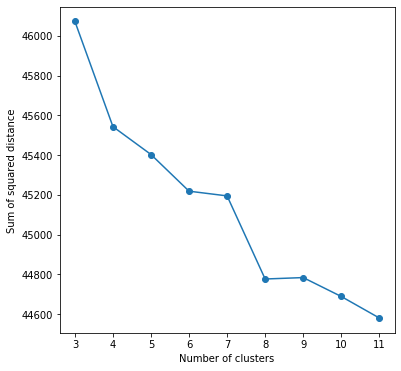

In [41]:
# We have used the minibatchKmeans for the evaulation criteria. To get faster output. However there is 
# not much significant difference in the sum of square distance value of the clusters for minibatchKmeans and Kmeans.
sse = []
list_k = list(range(3, 12))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k,verbose=10)
    km.fit(all_features)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance')

# Graph for Silhouette Score for a range of clusters  5,6,7,8,9
## This is to estimate the optimal number of clusters

* <font size="4"> The Silhoette co-efficient measures the average distance between a data point in a cluster to all the other data points in the same cluster and also the average distance between a data point in a cluster and all the other data points in the nearest cluster </font>
* <font size="4"> The best clusters are chosen which has the minimum average distance between the points int the same cluster and maximum possible average distance between points in the nearest cluster </font>
* <font size="4"> Based on the output from the above elbow method we decided to perform silhouette score to find the optimal number of clusters for the given dataset. </font>
* <font size="4"> The graph we have plotted below displays the silhouette scores for cluster values k=5,6,7,8,9. </font>
* <font size="4"> As we have used TfIdfVectorizer in our project, it assigns low values to every datapoint due to which the silhouette scores for the clusters are close to zero.</font>
* <font size="4"> We have chosen the value of k=7 because according to the plotted graphs, for k=7 majority of the silhouette coeffients for the clusters stay in the +ve region. </font>
* <font size="4"> The clusters that are plotted in the -ve region has data points belonging to the wrong clusters. </font>

Init 1/3 with method: k-means++
Inertia for init 1/3: 280.455864
Init 2/3 with method: k-means++
Inertia for init 2/3: 283.532729
Init 3/3 with method: k-means++
Inertia for init 3/3: 280.510424
Minibatch iteration 1/48400: mean batch inertia: 0.963632, ewa inertia: 0.963632 
Minibatch iteration 2/48400: mean batch inertia: 0.945730, ewa inertia: 0.963558 
Minibatch iteration 3/48400: mean batch inertia: 0.950740, ewa inertia: 0.963505 
Minibatch iteration 4/48400: mean batch inertia: 0.956679, ewa inertia: 0.963477 
Minibatch iteration 5/48400: mean batch inertia: 0.961667, ewa inertia: 0.963470 
Minibatch iteration 6/48400: mean batch inertia: 0.958921, ewa inertia: 0.963451 
Minibatch iteration 7/48400: mean batch inertia: 0.955610, ewa inertia: 0.963419 
Minibatch iteration 8/48400: mean batch inertia: 0.954380, ewa inertia: 0.963381 
Minibatch iteration 9/48400: mean batch inertia: 0.947964, ewa inertia: 0.963317 
Minibatch iteration 10/48400: mean batch inertia: 0.950262, ewa ine

Minibatch iteration 269/48400: mean batch inertia: 0.938300, ewa inertia: 0.951063 
Minibatch iteration 270/48400: mean batch inertia: 0.947496, ewa inertia: 0.951048 
Minibatch iteration 271/48400: mean batch inertia: 0.960891, ewa inertia: 0.951089 
Minibatch iteration 272/48400: mean batch inertia: 0.941207, ewa inertia: 0.951048 
Minibatch iteration 273/48400: mean batch inertia: 0.942270, ewa inertia: 0.951012 
Minibatch iteration 274/48400: mean batch inertia: 0.945059, ewa inertia: 0.950987 
Minibatch iteration 275/48400: mean batch inertia: 0.942024, ewa inertia: 0.950950 
Minibatch iteration 276/48400: mean batch inertia: 0.941062, ewa inertia: 0.950909 
Minibatch iteration 277/48400: mean batch inertia: 0.952712, ewa inertia: 0.950917 
Minibatch iteration 278/48400: mean batch inertia: 0.937986, ewa inertia: 0.950863 
Minibatch iteration 279/48400: mean batch inertia: 0.954003, ewa inertia: 0.950876 
Minibatch iteration 280/48400: mean batch inertia: 0.937256, ewa inertia: 0.

Init 1/3 with method: k-means++
Inertia for init 1/3: 280.323621
Init 2/3 with method: k-means++
Inertia for init 2/3: 281.755151
Init 3/3 with method: k-means++
Inertia for init 3/3: 281.505744
Minibatch iteration 1/48400: mean batch inertia: 0.976371, ewa inertia: 0.976371 
Minibatch iteration 2/48400: mean batch inertia: 0.967670, ewa inertia: 0.976335 
Minibatch iteration 3/48400: mean batch inertia: 0.957413, ewa inertia: 0.976256 
Minibatch iteration 4/48400: mean batch inertia: 0.961124, ewa inertia: 0.976194 
Minibatch iteration 5/48400: mean batch inertia: 0.965241, ewa inertia: 0.976149 
Minibatch iteration 6/48400: mean batch inertia: 0.956367, ewa inertia: 0.976067 
Minibatch iteration 7/48400: mean batch inertia: 0.956327, ewa inertia: 0.975985 
Minibatch iteration 8/48400: mean batch inertia: 0.952183, ewa inertia: 0.975887 
Minibatch iteration 9/48400: mean batch inertia: 0.957014, ewa inertia: 0.975809 
Minibatch iteration 10/48400: mean batch inertia: 0.956061, ewa ine

Minibatch iteration 270/48400: mean batch inertia: 0.950826, ewa inertia: 0.957128 
Minibatch iteration 271/48400: mean batch inertia: 0.941446, ewa inertia: 0.957063 
Minibatch iteration 272/48400: mean batch inertia: 0.945063, ewa inertia: 0.957013 
Minibatch iteration 273/48400: mean batch inertia: 0.953468, ewa inertia: 0.956999 
Minibatch iteration 274/48400: mean batch inertia: 0.944819, ewa inertia: 0.956948 
Minibatch iteration 275/48400: mean batch inertia: 0.948290, ewa inertia: 0.956913 
Minibatch iteration 276/48400: mean batch inertia: 0.950161, ewa inertia: 0.956885 
Minibatch iteration 277/48400: mean batch inertia: 0.940411, ewa inertia: 0.956817 
Minibatch iteration 278/48400: mean batch inertia: 0.949144, ewa inertia: 0.956785 
Minibatch iteration 279/48400: mean batch inertia: 0.941084, ewa inertia: 0.956720 
Minibatch iteration 280/48400: mean batch inertia: 0.948153, ewa inertia: 0.956684 
Minibatch iteration 281/48400: mean batch inertia: 0.941704, ewa inertia: 0.

Minibatch iteration 568/48400: mean batch inertia: 0.950165, ewa inertia: 0.949226 
Minibatch iteration 569/48400: mean batch inertia: 0.947872, ewa inertia: 0.949220 
Minibatch iteration 570/48400: mean batch inertia: 0.941492, ewa inertia: 0.949188 
Minibatch iteration 571/48400: mean batch inertia: 0.953131, ewa inertia: 0.949205 
Minibatch iteration 572/48400: mean batch inertia: 0.946349, ewa inertia: 0.949193 
Minibatch iteration 573/48400: mean batch inertia: 0.945031, ewa inertia: 0.949176 
Minibatch iteration 574/48400: mean batch inertia: 0.944283, ewa inertia: 0.949155 
Minibatch iteration 575/48400: mean batch inertia: 0.951089, ewa inertia: 0.949163 
Minibatch iteration 576/48400: mean batch inertia: 0.947363, ewa inertia: 0.949156 
Minibatch iteration 577/48400: mean batch inertia: 0.946486, ewa inertia: 0.949145 
Minibatch iteration 578/48400: mean batch inertia: 0.948922, ewa inertia: 0.949144 
Minibatch iteration 579/48400: mean batch inertia: 0.944355, ewa inertia: 0.

Init 1/3 with method: k-means++
Inertia for init 1/3: 278.386600
Init 2/3 with method: k-means++
Inertia for init 2/3: 277.623485
Init 3/3 with method: k-means++
Inertia for init 3/3: 280.229091
Minibatch iteration 1/48400: mean batch inertia: 0.966201, ewa inertia: 0.966201 
Minibatch iteration 2/48400: mean batch inertia: 0.963011, ewa inertia: 0.966188 
Minibatch iteration 3/48400: mean batch inertia: 0.953328, ewa inertia: 0.966135 
Minibatch iteration 4/48400: mean batch inertia: 0.950020, ewa inertia: 0.966068 
Minibatch iteration 5/48400: mean batch inertia: 0.954158, ewa inertia: 0.966019 
Minibatch iteration 6/48400: mean batch inertia: 0.957645, ewa inertia: 0.965984 
Minibatch iteration 7/48400: mean batch inertia: 0.953117, ewa inertia: 0.965931 
Minibatch iteration 8/48400: mean batch inertia: 0.946133, ewa inertia: 0.965849 
Minibatch iteration 9/48400: mean batch inertia: 0.955345, ewa inertia: 0.965806 
Minibatch iteration 10/48400: mean batch inertia: 0.947219, ewa ine

Minibatch iteration 244/48400: mean batch inertia: 0.941591, ewa inertia: 0.948432 
Minibatch iteration 245/48400: mean batch inertia: 0.941401, ewa inertia: 0.948403 
Minibatch iteration 246/48400: mean batch inertia: 0.939480, ewa inertia: 0.948366 
Minibatch iteration 247/48400: mean batch inertia: 0.942606, ewa inertia: 0.948343 
Minibatch iteration 248/48400: mean batch inertia: 0.924228, ewa inertia: 0.948243 
Minibatch iteration 249/48400: mean batch inertia: 0.934410, ewa inertia: 0.948186 
Minibatch iteration 250/48400: mean batch inertia: 0.921370, ewa inertia: 0.948075 
Minibatch iteration 251/48400: mean batch inertia: 0.930615, ewa inertia: 0.948003 
Minibatch iteration 252/48400: mean batch inertia: 0.928898, ewa inertia: 0.947924 
Minibatch iteration 253/48400: mean batch inertia: 0.938804, ewa inertia: 0.947886 
Minibatch iteration 254/48400: mean batch inertia: 0.933873, ewa inertia: 0.947828 
Minibatch iteration 255/48400: mean batch inertia: 0.926710, ewa inertia: 0.

Minibatch iteration 531/48400: mean batch inertia: 0.931589, ewa inertia: 0.937528 
Minibatch iteration 532/48400: mean batch inertia: 0.944529, ewa inertia: 0.937557 
Minibatch iteration 533/48400: mean batch inertia: 0.928993, ewa inertia: 0.937521 
Minibatch iteration 534/48400: mean batch inertia: 0.940003, ewa inertia: 0.937532 
Minibatch iteration 535/48400: mean batch inertia: 0.943053, ewa inertia: 0.937555 
Minibatch iteration 536/48400: mean batch inertia: 0.921937, ewa inertia: 0.937490 
Minibatch iteration 537/48400: mean batch inertia: 0.942098, ewa inertia: 0.937509 
Minibatch iteration 538/48400: mean batch inertia: 0.948201, ewa inertia: 0.937553 
Minibatch iteration 539/48400: mean batch inertia: 0.937872, ewa inertia: 0.937555 
Minibatch iteration 540/48400: mean batch inertia: 0.948081, ewa inertia: 0.937598 
Minibatch iteration 541/48400: mean batch inertia: 0.930950, ewa inertia: 0.937571 
Minibatch iteration 542/48400: mean batch inertia: 0.923674, ewa inertia: 0.

Minibatch iteration 228/48400: mean batch inertia: 0.939698, ewa inertia: 0.946944 
Minibatch iteration 229/48400: mean batch inertia: 0.936262, ewa inertia: 0.946900 
Minibatch iteration 230/48400: mean batch inertia: 0.933232, ewa inertia: 0.946843 
Minibatch iteration 231/48400: mean batch inertia: 0.924751, ewa inertia: 0.946752 
Minibatch iteration 232/48400: mean batch inertia: 0.929985, ewa inertia: 0.946683 
Minibatch iteration 233/48400: mean batch inertia: 0.942253, ewa inertia: 0.946664 
Minibatch iteration 234/48400: mean batch inertia: 0.943172, ewa inertia: 0.946650 
Minibatch iteration 235/48400: mean batch inertia: 0.923163, ewa inertia: 0.946553 
Minibatch iteration 236/48400: mean batch inertia: 0.944279, ewa inertia: 0.946543 
Minibatch iteration 237/48400: mean batch inertia: 0.920463, ewa inertia: 0.946435 
Minibatch iteration 238/48400: mean batch inertia: 0.914633, ewa inertia: 0.946304 
Minibatch iteration 239/48400: mean batch inertia: 0.938035, ewa inertia: 0.

Minibatch iteration 488/48400: mean batch inertia: 0.937738, ewa inertia: 0.935414 
Minibatch iteration 489/48400: mean batch inertia: 0.937373, ewa inertia: 0.935422 
Converged (lack of improvement in inertia) at iteration 489/48400
Computing label assignment and total inertia
Init 1/3 with method: k-means++
Inertia for init 1/3: 275.333400
Init 2/3 with method: k-means++
Inertia for init 2/3: 276.986619
Init 3/3 with method: k-means++
Inertia for init 3/3: 274.451086
Minibatch iteration 1/48400: mean batch inertia: 0.950170, ewa inertia: 0.950170 
Minibatch iteration 2/48400: mean batch inertia: 0.955065, ewa inertia: 0.950190 
Minibatch iteration 3/48400: mean batch inertia: 0.950864, ewa inertia: 0.950193 
Minibatch iteration 4/48400: mean batch inertia: 0.950412, ewa inertia: 0.950194 
Minibatch iteration 5/48400: mean batch inertia: 0.950229, ewa inertia: 0.950194 
Minibatch iteration 6/48400: mean batch inertia: 0.940848, ewa inertia: 0.950155 
Minibatch iteration 7/48400: mean 

Minibatch iteration 225/48400: mean batch inertia: 0.932210, ewa inertia: 0.939321 
Minibatch iteration 226/48400: mean batch inertia: 0.939230, ewa inertia: 0.939321 
Minibatch iteration 227/48400: mean batch inertia: 0.930622, ewa inertia: 0.939285 
Minibatch iteration 228/48400: mean batch inertia: 0.946337, ewa inertia: 0.939314 
Minibatch iteration 229/48400: mean batch inertia: 0.941820, ewa inertia: 0.939325 
Minibatch iteration 230/48400: mean batch inertia: 0.948862, ewa inertia: 0.939364 
Minibatch iteration 231/48400: mean batch inertia: 0.929716, ewa inertia: 0.939324 
Minibatch iteration 232/48400: mean batch inertia: 0.919630, ewa inertia: 0.939243 
Minibatch iteration 233/48400: mean batch inertia: 0.909939, ewa inertia: 0.939122 
Minibatch iteration 234/48400: mean batch inertia: 0.940888, ewa inertia: 0.939129 
Minibatch iteration 235/48400: mean batch inertia: 0.934940, ewa inertia: 0.939111 
Minibatch iteration 236/48400: mean batch inertia: 0.924525, ewa inertia: 0.

Minibatch iteration 487/48400: mean batch inertia: 0.899063, ewa inertia: 0.932815 
Minibatch iteration 488/48400: mean batch inertia: 0.933519, ewa inertia: 0.932818 
Minibatch iteration 489/48400: mean batch inertia: 0.917642, ewa inertia: 0.932756 
Minibatch iteration 490/48400: mean batch inertia: 0.933594, ewa inertia: 0.932759 
Minibatch iteration 491/48400: mean batch inertia: 0.928976, ewa inertia: 0.932743 
Minibatch iteration 492/48400: mean batch inertia: 0.928488, ewa inertia: 0.932726 
Minibatch iteration 493/48400: mean batch inertia: 0.928906, ewa inertia: 0.932710 
Minibatch iteration 494/48400: mean batch inertia: 0.940542, ewa inertia: 0.932742 
Minibatch iteration 495/48400: mean batch inertia: 0.931422, ewa inertia: 0.932737 
Minibatch iteration 496/48400: mean batch inertia: 0.935738, ewa inertia: 0.932749 
Minibatch iteration 497/48400: mean batch inertia: 0.937122, ewa inertia: 0.932767 
Minibatch iteration 498/48400: mean batch inertia: 0.927337, ewa inertia: 0.

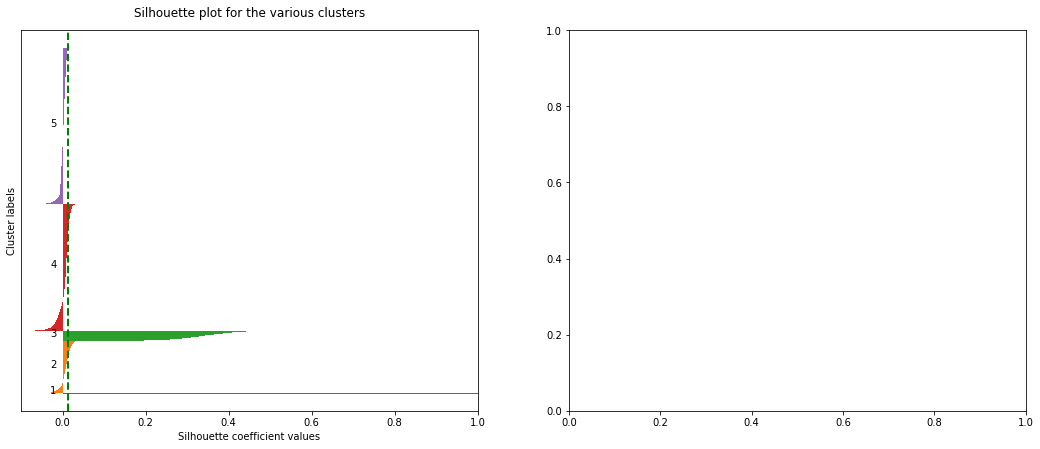

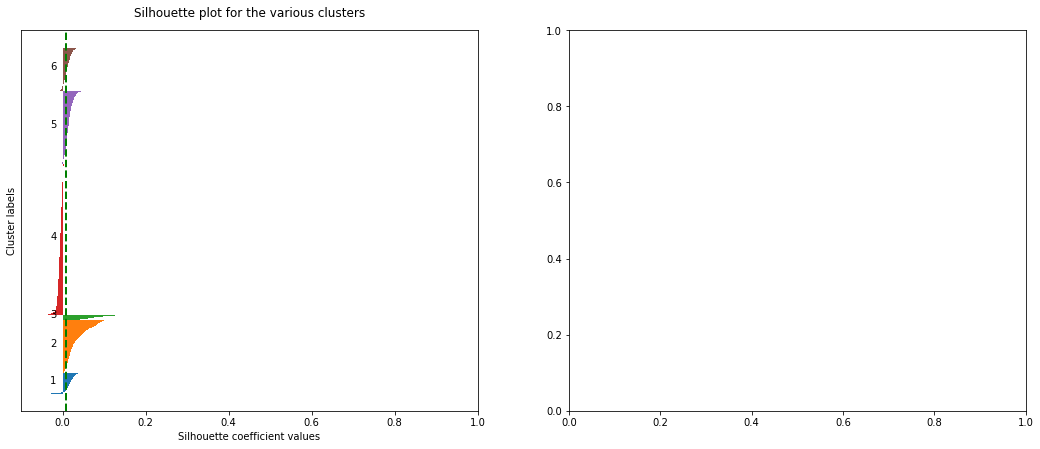

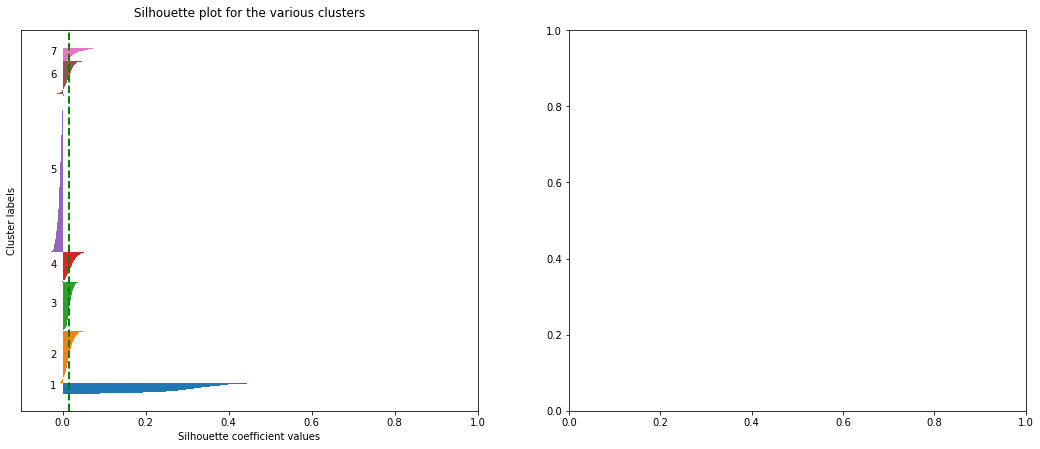

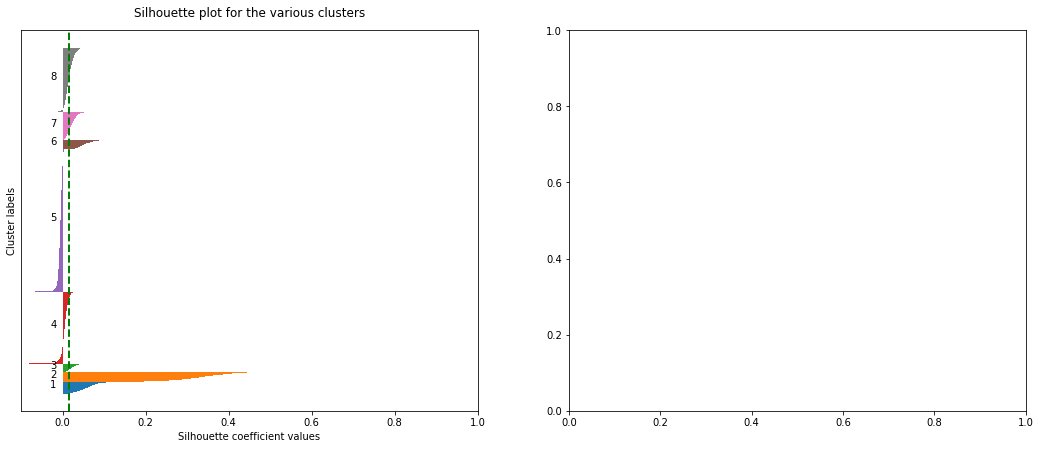

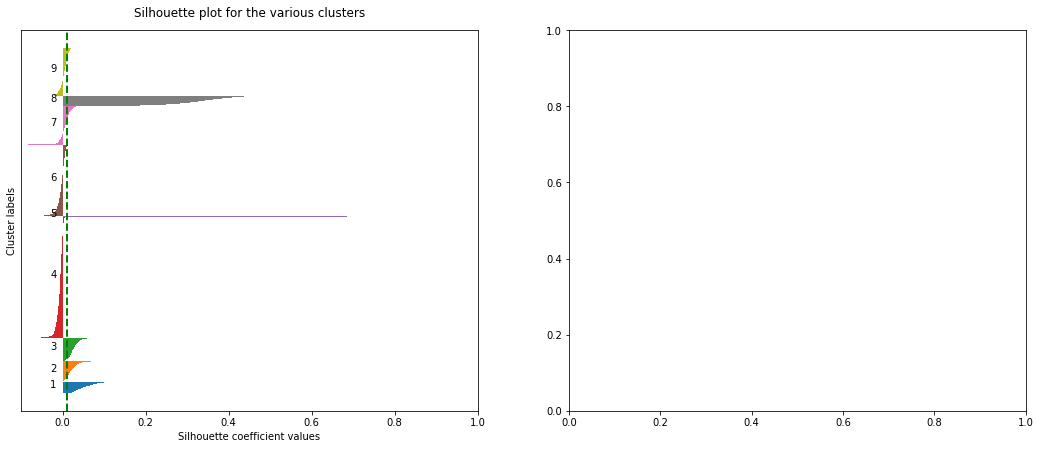

In [44]:
%%time
for i, k in enumerate([5,6,7,8,9]):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = MiniBatchKMeans(n_clusters=k,verbose=10)
    labels = km.fit_predict(all_features)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(all_features, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02)
    
    

# Clustering using k-means
* <font size="4"> We have used k-means clustering method to cluster documents in our project as it can perform well with large datasets</font>
* <font size="4"> Since, we deal with clusters having different shapes, densities and sizes, K-means is the best choice of clustering algorithm.</font>
* <font size="4"> We have assigned cluster number to every document after clustering.</font>
* <font size="4"> The function returns a dataframe with the document id and assigned cluster number.</font>


In [39]:
number_of_cluster = 7

In [88]:
def create_cluster(all_features):
    # Provided a random state so that the Kmeans provides the same output everytime we run it.
    kmcl = KMeans(n_clusters=number_of_cluster, verbose = 10,random_state=42,n_jobs=-1)
    kmcl.fit(all_features)
    cluster_labels = kmcl.labels_
    cluster_ids = pd.DataFrame(cluster_labels, columns=['Cluster ID'])
    cluster_ids.index.name = 'Doc_ID'
    doc_id = list(range(0,len(kmcl.labels_)))
    doc_values = dict()
    # Creating a dictionary with cluster id as key and list of documents associated with the cluster as value.
    for i in doc_id:
        if kmcl.labels_[i] in doc_values:
            doc_values[kmcl.labels_[i]].append(i)
        else:
            doc_values[kmcl.labels_[i]] = [i]
    return kmcl,doc_values,cluster_ids

In [89]:
kmcl,doc_values,cluster_ids = create_cluster(all_features)

# Function to evaluate the quality of the clusters using the silhouette score

In [92]:
#Function to evaluate the cluster score.
def evaluate_cluster(cluster_model,values):
    labels = cluster_model.labels_
    score = silhouette_score(values, labels, metric='euclidean')
    return score

In [96]:
# As mentioned above, we are using Tfidf due to which the silhouette score is low.
print('Average Silhouette score for the clusters: ',evaluate_cluster(kmcl,all_features))

Average Silhouette score for the clusters:  0.017982874867146146


# Training a different classifier for each cluster 
## (using k-fold cross validation)

* <font size="4"> In this we have selected all the 5 classifiers used in the first assignment and applied them to different clusters in repeating way. i.e after first 5 classifiers, it will again start with the first classifier for the next cluster. </font>
* <font size="4"> As MNBClassifier and SVMClassifier cannot handle multiple labels by default, we have used OneVsRestClassifier so that both of these classifiers can work properly with our multi-label documents.</font>
* <font size="4">We have made sure that we use the best possible parameters for each classifier based on our first assignment results. ie. kernel='linear for SVC and solver='adam' for MLPClassifier. </font>
* <font size="4"> We have also made sure that we trained each classifier with 10 KFolds. We have used 'accuracy' as the measure to evaluate the classifiers, as we have used the same for the deep neural network in Keras model. </font>

In [59]:
def get_accuracy_score(classifier,X_test,y_test):
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    return score

In [99]:
def classifier_for_cluster(doc_values,classifiers):
    classifiers_index = 0
    #going through every clusters
    for i in range(0,number_of_cluster):
        documents = doc_values.get(i)
        features=None
        clust_labels = []
        #going through every documents in the cluster
        for j in documents:
            if(features is None):
                features = all_features[j]
            else:
                a = features
                b = all_features[j]
                features = vstack((a,b))
            clust_labels.append(multi_labels[j])
        if(classifiers_index == len(classifiers)):
            classifiers_index = 0
        classifier = classifiers[classifiers_index]
        classifiers_index = classifiers_index + 1
        kfold_number = 10
        #Performing K-Folds
        kf = KFold(n_splits=kfold_number)
        kf.get_n_splits(features)
        classifier_score = []
        clust_labels = np.array(clust_labels)
        for train_index, test_index in kf.split(features):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = clust_labels[train_index], clust_labels[test_index]
            classifier.fit(X_train,y_train)
            classifier_score.append(get_accuracy_score(classifier,X_test,y_test))

        cluster_classifier_score.append(sum(classifier_score)/kfold_number)
        print("Classifier Score for cluster",i+1,": ",sum(classifier_score)/kfold_number)

In [100]:
# Creating a list of classifiers to train on the clusters data
classifiers = []
MNB_classifier = OneVsRestClassifier(MultinomialNB(alpha=0.005))
DT_classifier = DecisionTreeClassifier(random_state=1000)
RF_classifier = RandomForestClassifier(random_state=1000,n_estimators=200,n_jobs=-1)
SVC_classifier = OneVsRestClassifier(SVC(kernel='linear'))
NN_classifier = MLPClassifier(solver='adam')
classifiers.append(MNB_classifier)
classifiers.append(SVC_classifier)
classifiers.append(RF_classifier)
classifiers.append(DT_classifier)
classifiers.append(NN_classifier)

classifiers_index = 0
cluster_classifier_score = []

classifier_for_cluster(doc_values,classifiers)

Classifier Score for cluster 1 :  0.3662815117102525
Classifier Score for cluster 2 :  0.8529660643659613
Classifier Score for cluster 3 :  0.41145061289987805
Classifier Score for cluster 4 :  0.3183756807038098
Classifier Score for cluster 5 :  0.7253415920946183
Classifier Score for cluster 6 :  0.6390188447799644
Classifier Score for cluster 7 :  0.8517699115044248


# Function to Extract meaningful features using Deep Autoencoder

* <font size="4"> We applied Autoencoder based on the Paper-1:
Liang, Hong et al. “Text feature extraction based on deep learning: a review.” EURASIP journal on wireless communications and networking vol. 2017,1 (2017): 211. doi:10.1186/s13638-017-0993-1 </font>

* <font size="4"> In this paper the author has explained various deep learning methods that can be used for the feature extractions. There were multiple options provided but as our data was purely based on text data, we decided to go with deep autoencoder to extract feature from the given set of text data. </font>


* <font size="4"> We have created a deep autoencoder that takes the features of every cluster and returns the encoded features which is exactly half the size of the passed feature size. </font>
* <font size="4"> In the deep autoencoder we have used 3 layers for encoding the features and 3 layers for decoding the features. </font>
* <font size="4"> We have used l1 & l2 regulizers to reduce the loss of the autoencoder and hence prevent overfitting and provide the best feature extraction. </font>
* <font size="4"> We can see a significant reduction in the loss when we train the autoencoder. This helps to improve the encoder performance</font>
* <font size="4"> For all of the layers(except the last one in the decoder layer) in the autoencoder we used 'relu' as our activation, as it helps the model to train faster and is the one recommended by the Keras team. </font>
* <font size="4"> 'relu' also provides a wider range to encode the features and it does not adjust the encoded valus due to a broad range. </font>
* <font size="4"> The TfidfVectorizer converts the features into a sparse matrix containg values ranging from 0 to 1.</font>
* <font size="4"> We used loss='binary_crossentropy' because the input features have a range of 0 to 1 and the output features are to be decoded in the same range.  </font>
* <font size="4"> For the last layer we used 'sigmoid' because, when the input features have a range of 0 to 1, it is recommended to use the activation function of the last layer as 'sigmoid' </font>
* <font size="4"> We used optimizer='adam' because Adam is the best optimizer when we are working large datasets having huge number of features as in our case. 'Adam also produces outcomes faster compared to other optimizers, and is memory efficient. Hence preferred for deep networks</font>


In [61]:
def get_autoencoder_features(features):
    ncol = features.shape[1]

    #Defining size for the hidden layers of the autoencoder
    encoding_1 = int(round(ncol/1.2))
    encoding_2 = int(round(ncol/1.5))
    encoding_dim = int(round(ncol/2))
    
    input_dim = Input(shape = (ncol, ))

    encoded1 = Dense(encoding_1, activation = 'relu',activity_regularizer=regularizers.l1_l2(l1=10e-8,l2=10e-8)) (input_dim)
    encoded2 = Dense(encoding_2, activation = 'relu',activity_regularizer=regularizers.l1_l2(l1=10e-8,l2=10e-8)) (encoded1)
    encoded3 = Dense(encoding_dim, activation = 'relu',activity_regularizer=regularizers.l1_l2(l1=10e-8,l2=10e-8)) (encoded2)
    
    decoded3 = Dense(encoding_2, activation = 'relu')(encoded3)
    decoded2 = Dense(encoding_1, activation = 'relu')(decoded3)
    decoded1 = Dense(ncol, activation = 'sigmoid')(decoded2)

    autoencoder = Model(inputs = input_dim, outputs = decoded1)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    trainX2,testX2 = train_test_split(features,test_size=0.2)
    
    autoencoder.fit(trainX2, trainX2, nb_epoch = 10, batch_size = 1000, shuffle = False, validation_data = (testX2, testX2))
    #predicting the encoded output based on the encoded layer
    encoder = Model(inputs = input_dim, outputs = encoded3)
    encoded_input = Input(shape = (encoding_dim, ))
    encoded_train = pd.DataFrame(encoder.predict(features))
    #returning the encoded features
    return encoded_train

In [62]:
# creating encoded features for all of the clusters
encoded_features = []
for i in range(0,number_of_cluster):
    documents = doc_values.get(i)
    features=None
    clust_labels = []
    for j in documents:
        if(features is None):
            features = all_features[j]
        else:
            a = features
            b = all_features[j]
            features = vstack((a,b))
        clust_labels.append(multi_labels[j])
    new_feature = get_autoencoder_features(features)
    encoded_features.append(new_feature)
    

Train on 14648 samples, validate on 3663 samples
Epoch 1/10
14648/14648 [==============================] - 126s 9ms/step - loss: 0.5260 - val_loss: 0.0411
Epoch 2/10
14648/14648 [==============================] - 129s 9ms/step - loss: 0.0368 - val_loss: 0.0147
Epoch 3/10
14648/14648 [==============================] - 128s 9ms/step - loss: 0.0112 - val_loss: 0.0092
Epoch 4/10
14648/14648 [==============================] - 126s 9ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 5/10
14648/14648 [==============================] - 126s 9ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 6/10
14648/14648 [==============================] - 124s 8ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/10
14648/14648 [==============================] - 124s 8ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 8/10
14648/14648 [==============================] - 124s 8ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 9/10
14648/14648 [==============================] - 125s 9ms/step - loss: 0.0084 - val_loss: 0.00

# Function to implement Deep Neural Network

* <font size="4"> For the final deep neural network, we have a created a simple deep neural network which has three layers. </font>
* <font size="4"> We have created this deep neural network for multi-label and multi-class classification.</font>
* <font size="4"> This deep neural network will take the encoded features from the autoencoder for each cluster, train on them and provide an output for the same. </font>
* <font size="4"> For the first two layers, we have used the acitvation of relu as it helps the model to train faster and is recommended by the Keras team.</font>
* <font size="4"> 'relu' also provides a wider range to encode the features and it does not adjust the encoded valus due to a broad range. </font>
* <font size="4"> We used optimizer='adam' because Adam is the best optimizer when we are working large datasets having huge number of features as in our case. 'Adam' also produces outcomes faster compared to other optimizers, and is memory efficient. Hence preferred for deep networks</font>
* <font size="4"> For the last layer we have used sigmoid as the activation function, instead of softmax as it calculates the probabiltiy of each class as independent from the other class and hence helps us in having multiple label as our output.</font>
* <font size="4"> If we were dealing with only multi class we would have used categorical crossentropy as our loss function but as we want to penalize each and every output node independelty of the other nodes(for multi-label), we have used the binary crossentropy as our loss function. </font>
* <font size="4"> We have also used KFold of 10 folds to train the deep neural network. </font>

In [73]:
def deep_neural_network(features,labels):
    labels_size = labels.shape[1]
    features = csr_matrix(features)
    input_dim = features.shape[1]
    #Defining size for the hidden layers of the autoencoder
    layer_1 = int(round(input_dim/3))
    layer_2 = int(round(layer_1/2))
    #We have used a sequential model for our deep neural network
    model = Sequential()
    model.add(layers.Dense(layer_1, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(layer_1, activation='relu'))
    model.add(layers.Dense(labels_size, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    #Performing Kfold for training the neural network
    kfold_number = 10
    kf = KFold(n_splits=kfold_number)
    kf.get_n_splits(features)
    deep_network_score = []
    clust_labels = np.array(labels)
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = clust_labels[train_index], clust_labels[test_index]
        model.fit(X_train,y_train, epochs=10,batch_size=500,verbose=0)
        deep_network_score.append(model.evaluate(X_test,y_test,verbose=0)[1])
        
    return sum(deep_network_score)/kfold_number

In [74]:
# For every clusters training the deep neural network with the new encoded features
for i in range(0,number_of_cluster):
    documents = doc_values.get(i)
    clust_labels = []
    for j in documents:
        clust_labels.append(multi_labels[j])
    # taking the encoded features
    features = encoded_features[i]
    clust_labels = np.array(clust_labels)
    deep_network_score = deep_neural_network(features,clust_labels)
    print("Score of deep neural network for cluster ",i+1,": ",deep_network_score)
    

Score of deep neural network for cluster  1 :  0.974214514096578
Score of deep neural network for cluster  2 :  0.9687356352806091
Score of deep neural network for cluster  3 :  0.9722237586975098
Score of deep neural network for cluster  4 :  0.9751835068066915
Score of deep neural network for cluster  5 :  0.996165911356608
Score of deep neural network for cluster  6 :  0.9782718221346537
Score of deep neural network for cluster  7 :  0.9955101013183594


# Changes we have introduced in the project with respect to the approach we have taken for Assignment-1
* <font size="4"> In Assignment-1, we have trained the classifiers with single labels. However, in our project we have considered the multiple labels tagged to every document. </font>
* <font size="4"> We have used MultilabelBinarizer to work with multiple labels assigned to a document in the project. </font>
* <font size="4"> In Assignment-1 we had split the data using train test split. However, in the project we have used k-fold cross validation to split the entire data into train and test data.</font>
* <font size="4"> K-fold iteratively split the train and test data into k-blocks by changing the testing block and the training blocks in every iteration. </font>
* <font size="4"> This helps in training the model to perform better. </font>
* <font size="4"> We have used Accuracy as our evaluation metric for the classifier. As we had to use the same for the deep neural network. </font>

## References
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://www.kaggle.com/saivarunk/dimensionality-reduction-using-keras-auto-encoder
* https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
* https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
* https://medium.com/datadriveninvestor/deep-learning-techniques-for-text-classification-9392ca9492c7
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/
